# Precipitation Metrics

Using a dataset of 5-minute rainfall records for the Manhattan station of the Kansas Mesonet we will examine the duration, amount, and maximum rainfall intensity of rainfall events. The goal of this exercise is to learn how extract and synthesize relevant information from long time series. Rainfall intensity is an important variable related to soil erosion, infiltration, surface and sub-suraface water runoff, and canopy interception.

We will assume that a rainfall event is not conditioned to a specific day or storm. A rainfall event will be defined by the period without rainfall between two rainfall records greater than zero. This will allow us to account for multiple rainfall events within the same storm. So, in long rainy days where it starts raining, then stops, and then it starts raininign again we will compute more than one event. This is probably more accurate than using daily data. Often times the problem is the lack of precipitation data at temporal resolutions finer than 60 minutes. But our dataset with 5-minute data will allow us to examine rainfall events with greater detail. Likely the maximum rainfall intensity using 5-minute data will result in larger magnitudes than using hourly data.

The data of this dataset is in millimeters and was recorded using a tipping bucket rain gauge (Texas Electronics), which sometimes can underestimate rainfall totals when the rainfall intensity is greater than about 50 mm per hour. This does not impose any restrictions for our data, but it is always good to know more about the limitations of our datasets.


In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
# Load rainfall data
data = pd.read_csv('../datasets/manhattan_5min_precip.csv')
data.head()


,timestamp,precipitation
0,01-05-2017 00:00,0.0
1,01-05-2017 00:05,0.0
2,01-05-2017 00:10,0.0
3,01-05-2017 00:15,0.0
4,01-05-2017 00:20,0.0


In [3]:
print(type(data.timestamp[0]))
data.timestamp = pd.to_datetime(data.timestamp, format='%d-%m-%Y %H:%M')
print(type(data.timestamp[0]))


<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


It is always a good idea to generate a plot of the data. This will allow you to detect any major anomaly of the dataset or required action before using the data. For instance, it is common to assign placeholder values such as -9999 to missing values. If the dataset contains some of these values they will show up in the plot. Plotting the data is also extremely useful to detect the maximum and minimum range of the variable and to detect large periods of missing data.

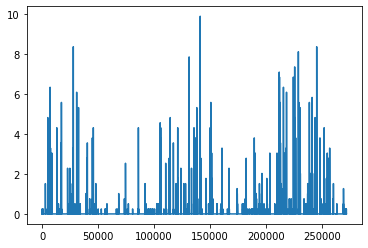

In [4]:
# Generate quick plot
plt.figure()
plt.plot(data["precipitation"])
plt.show()

In [5]:
# Check if there are any missing values
idx_missing = data["precipitation"].isna()
percent_missing = np.round(np.sum(idx_missing)/data.shape[0]*100,2)

print('There are', np.sum(idx_missing), 'missing values.')
print('Missing values represent', str(percent_missing),'% of the dataset')


There are 101 missing values.
Missing values represent 0.04 % of the dataset


In [6]:
# Iterate over the time series of 5-minute rainfall

# Create DataFrame to store summary metrics
df = pd.DataFrame()
df.insert(0, 'start_time', '')
df.insert(1, 'end_time', '')
df.insert(2, 'duration', np.array([]))
df.insert(3, 'total', np.array([]))
df.insert(4, 'max_intensity', np.array([]))


interval = 5                # minutes over which rainfall data was collected
event_interval = 5          # maximum elapsed minutes between rainfall events
event_counter = 0           # counter of rainfall events
period_without_rainfall = 0 # Track time without rainfall events
event_duration = 0          # Duration of the rainfall event
event_total = 0             # Total number of millimeters
event_max_intensity = 0     # Max rainfall intensity (converted to mm/hr)
within_event = False        # Boolean inside/outside a rain event

for i,rain in enumerate(data["precipitation"]):
    
    # If rainfall is greater than zero that means we are inside a rainfall event
    if rain > 0:
        #period_without_rainfall = 0 # Reset period_without_rainfall
    
        # Set parameters if this the first entry greater than zero rainfall
        if not within_event:
            within_event = True
            event_counter += 1;
            event_start_time = data["timestamp"][i]

        # Track duration, amount, and intensity of the precipitation event
        event_duration += interval
        event_total += rain
        event_max_intensity = max(event_max_intensity,rain)

    else:
        period_without_rainfall += interval

    # End of the rainfall event if there is a certain cumulative time without rainfall
    if within_event and rain == 0: #period_without_rainfall >= event_interval:
        
        # Get timestamp of last entry fo this event. Noticed that this timestamp may not
        # be the last rainfall record, but it could be the timestamp of the 
        event_end_time = data.timestamp[i-1] # Previous timestep had the last rain > 0

        df.loc[event_counter-1] = [event_start_time, 
                                   event_end_time, 
                                   event_duration, 
                                   event_total, 
                                   event_max_intensity*60/5]
        within_event = False
        event_start_time = ''
        event_end_time = ''
        event_duration = 0
        event_total = 0
        event_max_intensity = 0
        
    if i == data.precipitation.shape[0]-1:
        print('Done')
        print('Detected:',df.shape[0],'rainfall events.')


Done
Detected: 1677 rainfall events.


In [7]:
df.head()

,start_time,end_time,duration,total,max_intensity
0,2017-05-01 01:25:00,2017-05-01 01:25:00,5.0,0.25,3.0
1,2017-05-01 02:55:00,2017-05-01 02:55:00,5.0,0.25,3.0
2,2017-05-02 22:45:00,2017-05-02 22:45:00,5.0,0.25,3.0
3,2017-05-03 03:15:00,2017-05-03 03:15:00,5.0,0.25,3.0
4,2017-05-03 03:45:00,2017-05-03 03:45:00,5.0,0.25,3.0


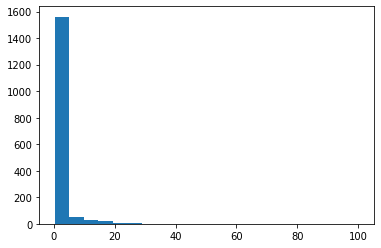

In [9]:
plt.figure()
plt.hist(df["total"], bins=21)
plt.show()

In [10]:
# Print some basic stats
print(np.percentile(df["total"],50))
print(np.percentile(df["total"],75))

0.25
0.75


In [12]:
# Plot cumulative time series of the 
idx_longest = df["duration"].idxmax()
idx_longest


1284

In [14]:
longest_date_range = pd.date_range(df["start_time"][idx_longest], 
                                   df["end_time"][idx_longest],
                                   freq='5min')
longest_date_range

DatetimeIndex(['2019-05-07 23:40:00', '2019-05-07 23:45:00',
               '2019-05-07 23:50:00', '2019-05-07 23:55:00',
               '2019-05-08 00:00:00', '2019-05-08 00:05:00',
               '2019-05-08 00:10:00', '2019-05-08 00:15:00',
               '2019-05-08 00:20:00', '2019-05-08 00:25:00',
               '2019-05-08 00:30:00', '2019-05-08 00:35:00',
               '2019-05-08 00:40:00', '2019-05-08 00:45:00',
               '2019-05-08 00:50:00', '2019-05-08 00:55:00',
               '2019-05-08 01:00:00', '2019-05-08 01:05:00',
               '2019-05-08 01:10:00', '2019-05-08 01:15:00',
               '2019-05-08 01:20:00', '2019-05-08 01:25:00',
               '2019-05-08 01:30:00', '2019-05-08 01:35:00',
               '2019-05-08 01:40:00', '2019-05-08 01:45:00',
               '2019-05-08 01:50:00', '2019-05-08 01:55:00',
               '2019-05-08 02:00:00', '2019-05-08 02:05:00',
               '2019-05-08 02:10:00', '2019-05-08 02:15:00',
               '2019-05-

In [16]:
all_idx_longest = data["timestamp"].isin(longest_date_range)


Let's prove to ourselves that the period we selected has, indeed, the same duration as recorded in the summary table. It is always advisable to run checkpoints to ensure we are not carrying errors.

For instance, when I ran this for the first time I noticed that the duration recorded in the summary table was one unit greater (59 5-minute intervals). This allowed me to discover that line `event_end_time = data.timestamp[i]` should have been `event_end_time = data.timestamp[i-1]`. If I hadn't run this step I would have never found that I was mistakenly considering an extra 5-minute interval! This can become even worse if the error starts to propagate into additional lines of code, making the debugging process a rather painful experience. So, make sure to check your work even if you think it is right. Nothing more rewarding that having some evidence proving that we are indeed correct and we are ready to move onto the next step.

In [17]:
print(sum(all_idx_longest))
print(df["duration"][idx_longest]/5)


58
58.0


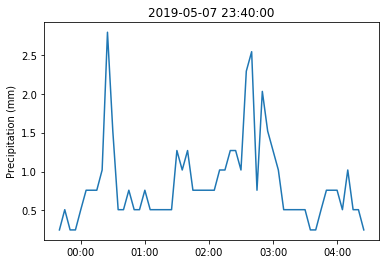

In [18]:
# Plot of precipitation for each 5-minute interval for the longest rainfall event
plt.plot(data["timestamp"][all_idx_longest], data["precipitation"][all_idx_longest])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.ylabel('Precipitation (mm)')
plt.title(df.start_time[idx_longest])
plt.show()

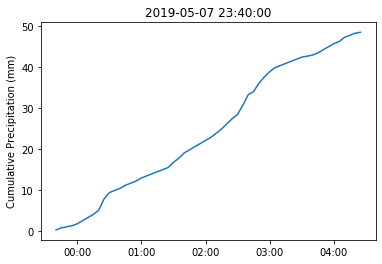

In [19]:
# Plot of cumulative rainfall
plt.figure()
plt.plot(data["timestamp"][all_idx_longest], data["precipitation"][all_idx_longest].cumsum())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.ylabel('Cumulative Precipitation (mm)')
plt.title(df["start_time"][idx_longest])
plt.show()